# Vehicle Detection
### by Kilian Muelken

---
#### Code Cell 1: necessary imports for the code

In [1]:
import numpy as np
import cv2
import glob
import time
from skimage.feature import hog
from moviepy.editor import VideoFileClip
from sklearn.cross_validation import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.externals import joblib

___
## Part 1: Vehicle detection functions
*Functions for the vehicle Detection*

### Part 1.1: Common functions

___
#### Code Cell ?: Calculate sliding windows
**Input:** image, start and stop positions in both x and y, window size (x and y dimensions),  and overlap fraction (for both x and y)<br>
**Output:** List of sliding windows

In [2]:
def calcSlideWindows(img):
    x_start = 0
    x_stop = img.shape[1]
    y_start = int(img.shape[0] * 0.5) # should be the highest place in the image, where cars can be seen
    y_stop = img.shape[0] * 1 # above the bonnet
    xy_window=(64, 64)
    xy_overlap=(0.5, 0.5)
        
    # Compute the span of the region to be searched    
    xspan = x_stop - x_start
    yspan = y_stop - y_start
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    
    # Initialize a list to append window positions to
    slidingWindows = []
    
    # Loop through finding x and y window positions
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start
            endy = starty + xy_window[1]
            
            # Append window position to list
            slidingWindows.append(((startx, starty), (endx, endy)))
    
    # Return the list of windows
    return slidingWindows

___
#### Code Cell ?: Plot and save images
**Input:** list of images<br>
**Output:** plots and saves images

In [3]:
def plotImage(imgs, save=False):
    # check if imgs is a list
    imglist = []
    
    if isinstance(imgs, list):
        imglist = imgs
    else:
        imglist.append(imgs)
        
    n_img = len(imglist)
    
    plt.figure(figsize=(20,5))
    
    for i in range(n_img):
        # plot image
        n_plot = 101 + n_img*10 + i
        plt.subplot(n_plot) # source: https://stackoverflow.com/questions/35692507/plot-several-image-files-in-matplotlib-subplots
        plt.imshow(imglist[i])
        
        # save image if save=true
        if save:
            #img_BGR = cv2.cvtColor(img_list[i],cv2.COLOR_RGB2BGR)
            img_name = 'image_'+time.strftime('%m_%Y_%H_%M_%S')+'.jpg'
            mpimg.imsave('output_images/'+img_name, imglist[i])

___
#### Code Cell ?: Draw bounding boxes
**Input:** image to draw the boxes, position and size of the boxes<br>
**Output:** image with boxes drawn

In [4]:
def drawBoxes(img, bboxes):
    color = (0, 0, 255) # Color of the boxes is blue
    thick = 6  # thickness of the boxes
    
    img_boxes = np.copy(img) # Make a copy of the image
    
    for bbox in bboxes: # Iterate through the bounding boxes
        cv2.rectangle(img_boxes, bbox[0], bbox[1], color, thick) # Draw a rectangle given bbox coordinates
    
    return img_boxes # return the image with boxes drawn

#### Code Cell ?: Read test images
**Input:** path of the test images<br>
**Output:** images with marked detected vehicles

In [5]:
def readImages(path):
    images = []
    images_list = glob.glob(path) # Make a list of calibration images

    # Step through the list, read test images and convert them to RGB
    for fname in images_list:
        img = cv2.imread(fname)
        rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        images.append(rgb)
    return images

___
#### Code Cell ?: Search for positive matches in windows
*Uses extractFeatures()*
**Input:** Image, Silde windows, Classifier, Scaler<br>
**Output:** positive matches in windows

In [6]:
def searchPositiveWindows(img, windows, clf, scaler):
    
    # Create an empty list to receive positive detection windows
    on_windows = []
    
    # Iterate over all windows in the list
    for window in windows:
        # Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        
        # Extract features for that window using single_img_features()
        features = extractFeatures(test_img)
        
        # Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        
        # Predict using your classifier
        prediction = clf.predict(test_features)
        
        # If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
            
    # Return windows for positive detections
    return on_windows

___
#### Code Cell ?: Find and eliminate false positive windows
**Input:** Detected windows with cars<br>
**Output:** Windows with eliminated false positives

In [7]:
def falsePositives(windows, last_windows):
    
    # Create an empty list to receive positive detection windows
    windows_eliminated = []
    
    # Iterate over all windows in the list
    for window in windows:
        xw1 = window[0][0] # x positition of the left upper point of the actual window
        yw1 = window[0][1] # y positition of the left upper point of the actual window
        xw2 = window[1][0] # x positition of the right bottom point of the actual window
        yw2 = window[1][1] # y positition of the right bottom point of the actual window
        
        for last_window in last_windows:
            xlw1 = last_window[0][0] # x positition of the left upper point of the last window
            ylw1 = last_window[0][1] # y positition of the left upper point of the last window
            xlw2 = last_window[1][0] # x positition of the right bottom point of the last window
            ylw2 = last_window[1][1] # y positition of the right bottom point of the last window
            
            # if left upper point of the actual window is in last window
            if (((xw1 > xlw1) & (xw1 < xlw2)) & ((yw1 > ylw1) & (yw1 < ylw2))):
                windows_eliminated.append(window)
            # if right bottom point of the actual window is in last window
            elif (((xw2 > xlw1) & (xw2 < xlw2)) & ((yw2 > ylw1) & (yw2 < ylw2))):
                windows_eliminated.append(window)
    
    return windows_eliminated

___
#### Code Cell ?: Find and merge mulitple detections
**Input:** Detected windows with cars<br>
**Output:** windows with merged multiple detections

In [8]:
def multipleDetections(windows):
    window_groups = []
    
    # Iterate over all windows in the list
    for window1 in windows:
        appendgroup = True
        
        # check if window is already in a window group
        for win_group in window_groups:
            if (window1 in win_group) & appendgroup:
                window_group = win_group
                appendgroup = False
                print('Window is in existing window group')
        
        if appendgroup:
            window_group = [] # group of windows with one multiple detection
            window_group.append(window1)
                
        windows.remove(window1) # delete current window from window list
        
        xw1 = window1[0][0] # x positition of the left upper point of the first window
        yw1 = window1[0][1] # y positition of the left upper point of the first window
        xw2 = window1[1][0] # x positition of the right bottom point of the first window
        yw2 = window1[1][1] # y positition of the right bottom point of the first window
        
        for window2 in windows:
            xlw1 = window2[0][0] # x positition of the left upper point of the other window
            ylw1 = window2[0][1] # y positition of the left upper point of the other window
            xlw2 = window2[1][0] # x positition of the right bottom point of the other window
            ylw2 = window2[1][1] # y positition of the right bottom point of the other window
            
            # if left upper point of the actual window is in last window
            if (((xw1 > xlw1) & (xw1 < xlw2)) & ((yw1 > ylw1) & (yw1 < ylw2))):
                window_group.append(window2)
            # if right bottom point of the actual window is in last window
            elif (((xw2 > xlw1) & (xw2 < xlw2)) & ((yw2 > ylw1) & (yw2 < ylw2))):
                window_group.append(window2)
                
        # append window group if it is a new group
        if appendgroup:
            window_groups.append(window_group)
    
    # calculate the total windows for each group
    windows_multiDetect = []
    
    for win_group in window_groups:
        x1 = 9999999
        y1 = 9999999
        x2 = 0
        y2 = 0
        
        for window1 in windows:
            xcw1 = window1[0][0] # x positition of the left upper point of the current window
            ycw1 = window1[0][1] # y positition of the left upper point of the current window
            xcw2 = window1[1][0] # x positition of the right bottom point of the current window
            ycw2 = window1[1][1] # y positition of the right bottom point of the current window
            
            if xcw1 < x1:
                x1 = xcw1
                
            if ycw1 < y1:
                y1 = ycw1
                
            if xcw2 > x2:
                x2 = xcw2
                
            if ycw2 > y2:
                y2 = ycw2
                
        total_window = ((x1, y1), (x2, y2))
        windows_multiDetect.append(total_window)
    
    return windows_multiDetect

___
### Part 1.2: Feature functions

___
#### Code Cell ?: Compute HOG features
**Input:** Image<br>
**Output:** HOG features

In [9]:
def hogFeatures(img):
    orientations = 9
    pix_per_cell = 8
    pixels_per_cell=(pix_per_cell, pix_per_cell)
    cell_per_block = 2
    cells_per_block=(cell_per_block, cell_per_block)
    block_norm = 'L2-Hys'
    transform_sqrt = True
    visualise = False
    feature_vector = True
    hog_channel = 0
    
    img_hog = img[:,:,hog_channel]
    
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(hog(img[:,:,channel], orientations, pixels_per_cell, cells_per_block, block_norm, transform_sqrt, visualise, feature_vector))
        features = np.ravel(hog_features)        
    else:
        #features = hog(img_hog, orientations, pixels_per_cell, cells_per_block, block_norm, transform_sqrt, visualise, feature_vector)
        features = hog(img_hog, orientations=orientations, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=visualise, feature_vector=feature_vector)
    return features

___
#### Code Cell ?: Compute binned color features 
**Input:** Image<br>
**Output:** binned color features

In [10]:
def binSpatial(img):
    size=(32, 32)
    
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    
    # Return the feature vector
    return features

___
#### Code Cell ?: Compute color histogram features 
**Input:** Image<br>
**Output:** binned color features

In [11]:
def colorHist(img):
    nbins=32
    bins_range=(0, 256) # NEED TO CHANGE bins_range if reading .png files with mpimg!
        
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    # Concatenate the histograms into a single feature vector
    features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    
    # Return the individual histograms, bin_centers and feature vector
    return features

___
#### Code Cell ?: Extract features 
*Uses hogFeatures(), binSpatial() and colorHist()*
**Input:** Image<br>
**Output:** features

In [12]:
def extractFeatures(imgs):
    color_space = 'RGB'
    spatial_feat = True
    hist_feat  =True
    hog_feat = True
    hog_channel = 0
    
    # check if imgs is a list
    if isinstance(imgs, list):
        imglist = imgs
    else:
        imglist = []
        imglist.append(imgs)
        
    # Create a list to append feature vectors to
    features = []
    
    for img in imglist:
        img_features = []
    
        # color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                    feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(img) 

        # Compute binned color features
        if spatial_feat == True:
            spatial_features = binSpatial(feature_image)
            img_features.append(spatial_features)
            

        # Compute color histogram features
        if hist_feat == True:
            hist_features = colorHist(feature_image)
            img_features.append(hist_features)
            

        # Compute HOG features
        if hog_feat == True:
            hog_features = hogFeatures(feature_image)
            img_features.append(hog_features)

        features.append(np.concatenate(img_features))
        
    # Return list of feature vectors
    return features

___
## Part ?: Training of the Classifier
*Training of the Classifier with test images*<br>

#### Code Cell ?: Training Pipeline
**Input:** path of the training images<br>
**Output:** trained classifier

In [13]:
def trainingPipeline(cars, notcars):
    n_cars = len(cars)
    n_notcars = len(notcars)
    
    if n_cars < n_notcars:
        notcars = notcars[0:n_cars]
    elif n_notcars < n_cars:
        cars = cars[0:n_notcars]
    
    car_features = extractFeatures(cars)
    notcar_features = extractFeatures(notcars)
        
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X_train)
    
    # Apply the scaler to X
    X_train = X_scaler.transform(X_train)
    X_test = X_scaler.transform(X_test)
    
    # Use a linear SVC 
    svc = LinearSVC()
    svc.fit(X_train, y_train)
    
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    
    return svc, X_scaler

In [14]:
# read train images
#notcars = readImages('train_nv/*.png')
#cars = readImages('train_v/*.png')

In [15]:
#clf, scaler = trainingPipeline(cars, notcars)

# save the classifier and scaler to the disk
# source: http://scikit-learn.org/stable/modules/model_persistence.html
#joblib.dump(clf, 'clf.pkl')
#joblib.dump(scaler, 'scaler.pkl')

In [16]:
# load the classifier and scaler
# source: http://scikit-learn.org/stable/modules/model_persistence.html
clf = joblib.load('clf.pkl')
scaler = joblib.load('scaler.pkl')

___
## Part ?: Testing
*Test of the Classifier with test images and test video*<br>

___
#### Code Cell ?: Image Testing Pipeline
*Test of the Classifier with test images*<br>
**Input:** path of the test images<br>
**Output:** images with marked detected vehicles

In [17]:
def imagePipeline(img):
    global last_windows # detected windows from the last image
    
    image = np.copy(img) # Make a copy of the image
    
    # calculate the searching windows
    slide_windows = calcSlideWindows(image)
    
    # find positive matches in searching windows
    windows_pos = searchPositiveWindows(image, slide_windows, clf, scaler)
    
    # delete false positives
    if 'last_windows' in globals():
        if len(last_windows) > 0:
            windows_pos_fp = falsePositives(windows_pos, last_windows)
    else:
        windows_pos_fp = windows_pos
    
    # save the detection for the next image
    last_windows = windows_pos
    
    # ToDo: merge multiple detections
    windows_pos_md = multipleDetections(windows_pos_fp)
    
    # draw the detections on the image
    res_img = drawBoxes(image, windows_pos_md)
    
    return res_img

Window is in existing window group
Window is in existing window group
Window is in existing window group


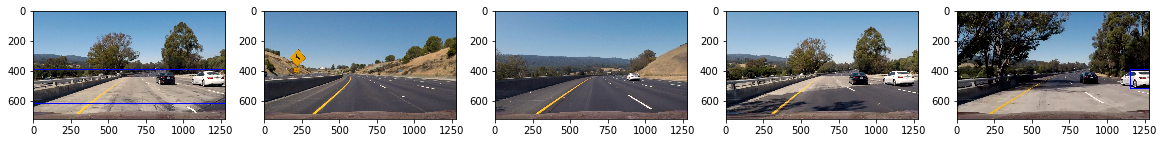

In [18]:
# read test images
test_images = readImages('test_images/*.jpg')

images = []

for test_image in test_images:
    # pipeline
    test_image_detected = imagePipeline(test_image)
    images.append(test_image_detected)
    
plotImage(images[0:5])

___
#### Code Cell ?: Video Pipeline
*Test of the Classifier with test video*<br>
**Input:** path of the test video<br>
**Output:** video with marked detected vehicles

In [19]:
def videoPipeline(img):
    # Sliding window
    res_img = imagePipeline(img)
    
    return res_img

#### Code Cell ?: Detect vehicles on video
**Input:** name of the test video<br>
**Output:** video with marked detected vehicles will be written in current folder

In [20]:
def detectVehicles(video_file_name):
    #clip = VideoFileClip(video_file_name+'.mp4')
    clip = VideoFileClip(video_file_name+'.mp4').subclip(14,15)
    video_clip = clip.fl_image(videoPipeline)
    %time video_clip.write_videofile(video_file_name+'_with_detected_vehicles.mp4', audio=False)

In [21]:
detectVehicles('project_video')

Window is in existing window group
[MoviePy] >>>> Building video project_video_with_detected_vehicles.mp4
[MoviePy] Writing video project_video_with_detected_vehicles.mp4


  0%|                                                                                           | 0/26 [00:00<?, ?it/s]

Window is in existing window group


 19%|███████████████▉                                                                   | 5/26 [00:05<00:21,  1.00s/it]

Window is in existing window group


 35%|████████████████████████████▋                                                      | 9/26 [00:08<00:16,  1.02it/s]

Window is in existing window group


 38%|███████████████████████████████▌                                                  | 10/26 [00:09<00:15,  1.03it/s]

Window is in existing window group


 46%|█████████████████████████████████████▊                                            | 12/26 [00:11<00:13,  1.01it/s]

Window is in existing window group


 50%|█████████████████████████████████████████                                         | 13/26 [00:12<00:12,  1.02it/s]

Window is in existing window group


 65%|█████████████████████████████████████████████████████▌                            | 17/26 [00:16<00:08,  1.03it/s]

Window is in existing window group


 73%|███████████████████████████████████████████████████████████▉                      | 19/26 [00:18<00:06,  1.03it/s]

Window is in existing window group


 81%|██████████████████████████████████████████████████████████████████▏               | 21/26 [00:20<00:04,  1.03it/s]

Window is in existing window group


 96%|██████████████████████████████████████████████████████████████████████████████▊   | 25/26 [00:24<00:00,  1.03it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_with_detected_vehicles.mp4 

Wall time: 25 s
